# 分析の方針
データ分析を行う上で、必ずデータを分析する目的を考慮した上で因果関係を考察する必要がある。そこで、因果関係は疫学でも触れられているが、統計学では原因系変数の種類と結果系変数の種類によって分析手法が異なるため、ここではデータの形状別の分析指針の一例を示す。

また、エビデンスレベルが変わってしまうが、原因系変数と結果系変数を逆にすることでより因果関係を考察する材料ができる。

## ライブラリのインポート

In [1]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

## データの読み込み

In [2]:
df = pd.read_csv("leukemia.csv")
df.head()

,t,status,sex,logWBC,Rx
0,35,0,1,1.45,0
1,34,0,1,1.47,0
2,32,0,1,2.20,0
3,32,0,1,2.53,0
4,25,0,1,1.78,0


## 原因が質的変数で結果が質的変数
因果関係の推論としてはリスク比やオッズ比を使用し、理論値と実測値との独立性を検証するにはカイ二乗検定を使用する。
### 前向き研究(コホート研究)
前向き研究では原因(曝露)から結果(症例)に向けてデータを集計する観察研究の手法。エビデンスレベルとしてRCTの次に高い。

In [3]:
cross1 = pd.crosstab(df["Rx"], df["status"])
cross1

status,0,1
Rx,,
0,12,9
1,0,21


status(生死)についてRx(投与群とプラセボ群)で違いが現れていることが分かる。

In [4]:
cross2 = pd.crosstab(df["sex"], df["status"])
cross2

status,0,1
sex,,
0,6,16
1,6,14


#### クロス集計表に性別の要素を加える
第三の変数を使用して結果に寄与する第三の要因を探す

In [5]:
cross3 = pd.crosstab([df["Rx"], df["sex"]], df["status"])
cross3

status  0   1
Rx sex       
0  0    6   5
   1    6   4
1  0    0  11
   1    0  10

この結果から性別による差は小さいことが分かる。

### 後ろ向き研究(症例対象研究)
報告された症例からデータを集計するため時間およびコストが前向き研究と比べてかからない代わりにエビデンスレベルは前向き研究より低い。

In [6]:
cross4 = pd.crosstab(df["status"], df["Rx"])
cross4

Rx,0,1
status,,
0,12,0
1,9,21


In [7]:
cross5 = pd.crosstab([df["status"], df["sex"]], df["Rx"])
cross5

Rx          0   1
status sex       
0      0    6   0
       1    6   0
1      0    5  11
       1    4  10

In [8]:
cross6 = pd.crosstab(df["status"], [df["Rx"], df["sex"]])
cross6

Rx      0      1    
sex     0  1   0   1
status              
0       6  6   0   0
1       5  4  11  10

## 原因が質的変数と結果が量的変数
### 基礎統計量
数値として厳密に分布を知るために平均値・最大値・四分位(中央値含む)・最小値・サンプル数を表示する。ここで現れたデータを基に因果関係を考察する。

In [9]:
df.describe()

,t,status,sex,logWBC,Rx
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,12.880952,0.714286,0.476190,2.930238,0.500000
std,9.347498,0.457230,0.505487,0.917522,0.506061
min,1.000000,0.000000,0.000000,1.450000,0.000000
25%,6.000000,0.000000,0.000000,2.302500,0.000000
50%,10.500000,1.000000,0.000000,2.800000,0.500000
75%,18.500000,1.000000,1.000000,3.490000,1.000000
max,35.000000,1.000000,1.000000,5.000000,1.000000


#### 質的変数によって場合分けをする

In [10]:
df_sex0 = df.query("sex==0")
df_sex1 = df.query("sex==1")
df_sex0.describe()

,t,status,sex,logWBC,Rx
count,22.000000,22.000000,22.0,22.000000,22.000000
mean,11.045455,0.727273,0.0,2.835455,0.500000
std,4.571936,0.455842,0.0,0.671443,0.511766
min,5.000000,0.000000,0.0,1.500000,0.000000
25%,8.000000,0.250000,0.0,2.312500,0.000000
50%,10.500000,1.000000,0.0,2.840000,0.500000
75%,12.750000,1.000000,0.0,3.165000,1.000000
max,22.000000,1.000000,0.0,4.430000,1.000000


In [11]:
df_sex1.describe()

,t,status,sex,logWBC,Rx
count,20.000000,20.000000,20.0,20.00000,20.000000
mean,14.900000,0.700000,1.0,3.03450,0.500000
std,12.540041,0.470162,0.0,1.13863,0.512989
min,1.000000,0.000000,1.0,1.45000,0.000000
25%,3.750000,0.000000,1.0,2.15250,0.000000
50%,12.000000,1.000000,1.0,2.68500,0.500000
75%,23.500000,1.000000,1.0,4.02250,1.000000
max,35.000000,1.000000,1.0,5.00000,1.000000


In [12]:
df_Rx0 = df.query("Rx==0")
df_Rx1 = df.query("Rx==1")
df_Rx0.describe()

,t,status,sex,logWBC,Rx
count,21.000000,21.000000,21.000000,21.000000,21.0
mean,17.095238,0.428571,0.476190,2.636190,0.0
std,9.999524,0.507093,0.511766,0.773876,0.0
min,6.000000,0.000000,0.000000,1.450000,0.0
25%,9.000000,0.000000,0.000000,2.160000,0.0
50%,16.000000,0.000000,0.000000,2.570000,0.0
75%,23.000000,1.000000,1.000000,2.960000,0.0
max,35.000000,1.000000,1.000000,4.430000,0.0


In [13]:
df_Rx1.describe()

,t,status,sex,logWBC,Rx
count,21.000000,21.0,21.000000,21.000000,21.0
mean,8.666667,1.0,0.476190,3.224286,1.0
std,6.467869,0.0,0.511766,0.972279,0.0
min,1.000000,1.0,0.000000,1.500000,1.0
25%,4.000000,1.0,0.000000,2.420000,1.0
50%,8.000000,1.0,0.000000,3.060000,1.0
75%,12.000000,1.0,1.000000,3.970000,1.0
max,23.000000,1.0,1.000000,5.000000,1.0


In [14]:
df_status0 = df.query("status==0")
df_status1 = df.query("status==1")
df_status0.describe()

,t,status,sex,logWBC,Rx
count,12.000000,12.0,12.000000,12.000000,12.0
mean,20.833333,0.0,0.500000,2.245833,0.0
std,10.590161,0.0,0.522233,0.538153,0.0
min,6.000000,0.0,0.000000,1.450000,0.0
25%,10.750000,0.0,0.000000,1.952500,0.0
50%,19.500000,0.0,0.500000,2.180000,0.0
75%,32.000000,0.0,1.000000,2.625000,0.0
max,35.000000,0.0,1.000000,3.200000,0.0


In [15]:
df_status1.describe()

,t,status,sex,logWBC,Rx
count,30.000000,30.0,30.000000,30.000000,30.000000
mean,9.700000,1.0,0.466667,3.204000,0.700000
std,6.659968,0.0,0.507416,0.899439,0.466092
min,1.000000,1.0,0.000000,1.500000,0.000000
25%,5.000000,1.0,0.000000,2.457500,0.000000
50%,8.000000,1.0,0.000000,3.055000,1.000000
75%,12.750000,1.0,1.000000,3.877500,1.000000
max,23.000000,1.0,1.000000,5.000000,1.000000


### 分布を箱ひげ図で確認
箱ひげ図を使用することで値の集中が確認できる。

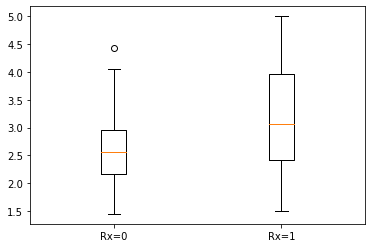

In [16]:
plt.boxplot([df_Rx0["logWBC"], df_Rx1["logWBC"]], labels=["Rx=0", "Rx=1"])
plt.show()

C:\Users\decar\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


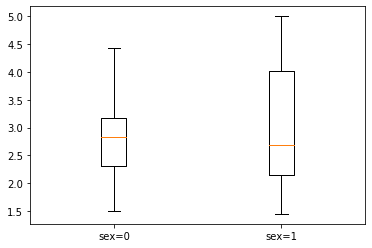

In [17]:
plt.boxplot([df_sex0["logWBC"], df_sex1["logWBC"]], labels=["sex=0", "sex=1"])
plt.show()

C:\Users\decar\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


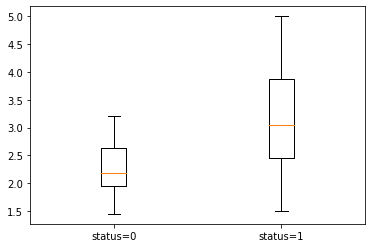

In [18]:
plt.boxplot([df_status0["logWBC"], df_status1["logWBC"]], labels=["status=0", "status=1"])
plt.show()

その他にもヒストグラムを使用してデータの詳細な分布を見ることもできるが、分割する数に注意が必要。

また、2変数間で平均値に差があるかを検証する時は対応のないT検定を使用する。

In [19]:
columns = ["Rx", "status", "sex"]
for col in columns:
    print("p-value col is %s, values is logWBC"%(col))
    xa = df.query("%s==0"%(col))["logWBC"]
    xb = df.query("%s==1"%(col))["logWBC"]
    f, p = stats.bartlett(xa, xb)
    if (2 * p) <= 0.05:
        t, p = stats.ttest_ind(xa, xb, equal_var=False)
    else:
        t, p = stats.ttest_ind(xa, xb, equal_var=True)
    print("%.2f"%(p))

p-value col is Rx, values is logWBC
0.04
p-value col is status, values is logWBC
0.00
p-value col is sex, values is logWBC
0.50


statusとRxについて値が異なることでそれぞれlogWBCについて有意差が現れていることが分かる。

## 原因が量的変数で結果が量的変数の場合
原因系変数も結果系変数も共に量的変数である場合は回帰係数などを使用して因果関係を明らかにする。ただし、係数がどの程度適合しているかを検証するために決定係数と自由度調整済み決定係数も見る。

### 原因系変数が1つの場合

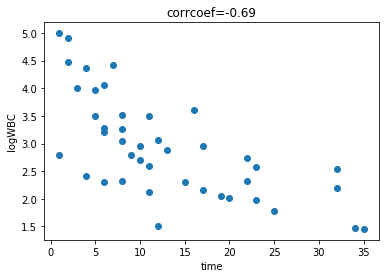

In [20]:
plt.scatter(df["t"], df["logWBC"])
plt.ylabel("logWBC")
plt.xlabel("time")
plt.title("corrcoef=%.2f"%(np.corrcoef(df["t"].values, df["logWBC"].values)[0][1]))
plt.show()

In [21]:
model1 = LinearRegression()
model1.fit(df["t"].values.reshape(-1, 1), df["logWBC"])
y_pred1 = model1.predict(df["t"].values.reshape(-1, 1))
a = model1.coef_[0]
b = model1.intercept_
R2 = r2_score(df["logWBC"], y_pred1)

C:\Users\decar\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\decar\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


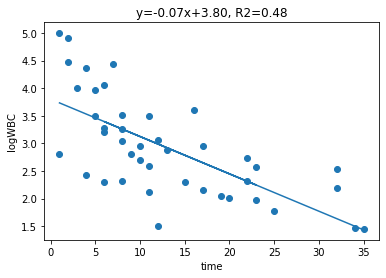

In [22]:
plt.scatter(df["t"], df["logWBC"])
plt.plot(df["t"], y_pred1)
plt.ylabel("logWBC")
plt.xlabel("time")
plt.title("y=%.2fx+%.2f, R2=%.2f"%(a, b, R2))
plt.show()

### 原因系変数が複数の場合

In [23]:
X = sm.add_constant(df.drop("logWBC", axis=1))
model2 = sm.OLS(df["logWBC"], X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logWBC   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     11.65
Date:                Tue, 03 Jan 2023   Prob (F-statistic):           3.19e-06
Time:                        22:27:42   Log-Likelihood:                -38.353
No. Observations:                  42   AIC:                             86.71
Df Residuals:                      37   BIC:                             95.40
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4360      0.330     10.408      0.000       2.767       4.105
t             -0.0685      0.013     -5.119      0.000      -0.096      -0.041
status         0.3399      0.306      1.112      0.273      -0.279       0.959
sex            0.4722      0.204      2.309      0.027       0.058       0.887
Rx            -0.1832      0.260     -0.703      0.486      -0.711       0.345
==============================================================================
Omnibus:                        0.957   Durbin-Watson:                   2.241
Prob(Omnibus):                  0.620   Jarque-Bera (JB):                0.879
Skew:                          -0.332   Prob(JB):                        0.644
Kurtosis:                       2.751   Cond. No.                         66.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 原因が量的変数で結果が質的変数の場合
原因系変数が量的変数で結果系変数が質的変数の場合は分類系教師あり学習を使用する。ここで、分かりやすい因果関係を明らかにする場合はロジスティック回帰や線形SVMなどを使用して決定境界の係数を使用する。ただし、係数の影響について考慮しやすくするためScikit-LearnではなくStatsmodelsを使用する。

### 原因系変数が一つの場合

In [24]:
X = sm.add_constant(df["logWBC"])
model3 = sm.Logit(df["status"], X).fit_regularized()
model3.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.45339720352061896
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 status   No. Observations:                   42
Model:                          Logit   Df Residuals:                       40
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Jan 2023   Pseudo R-squ.:                  0.2422
Time:                        22:27:42   Log-Likelihood:                -19.043
converged:                       True   LL-Null:                       -25.127
Covariance Type:            nonrobust   LLR p-value:                 0.0004858
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0344      1.771     -2.278      0.023      -7.505      -0.563
logWBC         1.8644      0.697      2.674      0.007       0.498       3.231
==============================================================================
"""

In [25]:
X = sm.add_constant(df.drop(["status"], axis=1))
model4 = sm.Logit(df["status"], X).fit_regularized()
model4.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.19982503727822173
            Iterations: 40
            Function evaluations: 43
            Gradient evaluations: 40


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 status   No. Observations:                   42
Model:                          Logit   Df Residuals:                       37
Method:                           MLE   Df Model:                            4
Date:                Tue, 03 Jan 2023   Pseudo R-squ.:                  0.6660
Time:                        22:27:42   Log-Likelihood:                -8.3927
converged:                       True   LL-Null:                       -25.127
Covariance Type:            nonrobust   LLR p-value:                 9.573e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0006      5.655     -0.884      0.377     -16.085       6.084
t             -0.2207      0.171     -1.291      0.197      -0.556       0.114
sex            4.2593      2.932      1.453      0.146      -1.486      10.005
logWBC         2.4628      1.881      1.309      0.190      -1.224       6.149
Rx            17.9450    750.688      0.024      0.981   -1453.377    1489.267
==============================================================================

Possibly complete quasi-separation: A fraction 0.50 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

他にも決定木の分類過程を可視化することで分類の順序関係を見ることでより複雑なデータの因果関係を考察することができる。